# Predicting Sale Price for Ames Iowa Housing Dataset
#### By: [Anthony Lucci](https://git.generalassemb.ly/anthonylucci?tab=repositories)

## Problem Statement

This projects seeks to create a regression model that can predict home sale prices in Ames, IA with similar accuracy to Zillow's Zestimate model. Zillow consumes a plethora of data into their model:
- Home details (bedrooms, square footage, etc.)
- Unique features (marble counters, pool house, etc.)
- On-market data (comparable homes listed/sold in area, etc.)
- Off-market data (tax assessments, foreclosures, etc.)
Zillow Zestimate's median %error on home sale prices in Iowa is +/-1.4%. This project will seek to match or beat that by building a regression model against the Ames Assessor Data for the period 2006-2010. The models will be optimized against root mean squared error (RMSE), and RMSE will be calculated as a % of mean sale price to compare against Zestimate.

## Executive Summary
The Ames Assessor Data featured a plethora of categorical columns that needed extensive transformation to be ready for analysis. This categorical data is specific to Ames and provided predictive power in the model that Zillow does not have. Theoretically, this should be an adavantage for our model. Working against us was the fact that the Ames dataset does not have off-market data, does not account for the price of nearby homes, and the fact that we are predicting with a single fitted model. Zillow almost surely uses an ensemble model that has been fine-tuned over the course of years by a large team.

|Model|Train R2|Test R2|RMSE|Pct RMSE of mean*|
|---|---|---|---|---|
|Model 1: MLR w/ Continuous Variables|0.8505|0.8560|25,854|14.2 pct|
|Model 2: MLR w/ Continuous Variables|0.8690|0.8820|23,939|13.2 pct|
|Model 3: Lasso w/ Full Numeric Set|0.9293|0.9175|18,951|10.4 pct|

None of the models had an R2 below 0.85 and all had low variance (<0.02 difference between train and test). The Lasso model outperformed all others, and was the one submitted to Kaggle. It explained approx. 92 percent of the variance in home sale prices.

The two variables most correlated with home sale price were Overall Quality and Greater Living Area. Overall quality is a subjective measure determined by the Ames assessor, and greater living area is an approximation of livable sqaure footage. It is unfortunate that the error of the Lasso model was only able to come within +/-10% of sale price despite an R2 of 0.92.

*Mean home sale price in Ames train set: $181,479

## Table of Contents
1. [Loading Data](#Loading-Data)
1. [Cleaning Data](#Cleaning-Data)
1. [Feature Engineering](#Feature-Engineering)
1. [Model Preparation: Baseline](#Model-Preparation:-Baseline)
1. [Model 1: MLR w/ Continuous Variables Only](#Model-1:-MLR-w/-Continuous-Variables-Only)
1. [Model 2: MLR w/ Continuous & Dummy Variables](#Model-2:-MLR-w/-Continuous-&-Dummy-Variables)
1. [Model 3: Lasso](#Model-3:-Lasso)
1. [Conclusion/Recommendations](#Conclusion/Recommendations)
1. [Kaggle Submission](#Kaggle-Submission)

## Loading Data

In [1]:
import warnings
warnings.filterwarnings("ignore") # Shhhh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
RANDOM_STATE = 90210

In [2]:
train_raw = pd.read_csv("./data/train.csv") # this is actually the full dataset

train_raw.shape

(2051, 81)

In [3]:
validation_raw = pd.read_csv("./data/test.csv") # this is actually the full dataset

# test set is missing the SalePrice column
validation_raw.shape

(878, 80)

In [4]:
# Adding a column to both datasets to specify train or test
train_raw["dataset"] = "train"
validation_raw["dataset"] = "validation"
# Adding a SalesPrice column to test data and filling it with zeros so I can concat both sets
validation_raw["SalePrice"] = 0

# combine train and test sets into one combined df without SalePrice
# the "dataset" column created above
combined = pd.concat([train_raw,validation_raw], axis=0)

# the row counts below match the individual train and test dataframes
combined["dataset"].value_counts()

train         2051
validation     878
Name: dataset, dtype: int64

In [5]:
# use mask to parse combined data into train and test sets
# I will perform all of my transformations to combined df and fit my regressions to train df
train = combined[combined["dataset"] == "train"]
validation = combined[combined["dataset"] == "validation"]

# check to make sure masks worked correctly
print(f"{len(train)}, {len(validation)}")

2051, 878


In [6]:
# MS SubClass is currently an int but should be an object based on data dict
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 877
Data columns (total 82 columns):
1st Flr SF         2929 non-null int64
2nd Flr SF         2929 non-null int64
3Ssn Porch         2929 non-null int64
Alley              198 non-null object
Bedroom AbvGr      2929 non-null int64
Bldg Type          2929 non-null object
Bsmt Cond          2849 non-null object
Bsmt Exposure      2846 non-null object
Bsmt Full Bath     2927 non-null float64
Bsmt Half Bath     2927 non-null float64
Bsmt Qual          2849 non-null object
Bsmt Unf SF        2928 non-null float64
BsmtFin SF 1       2928 non-null float64
BsmtFin SF 2       2928 non-null float64
BsmtFin Type 1     2849 non-null object
BsmtFin Type 2     2848 non-null object
Central Air        2929 non-null object
Condition 1        2929 non-null object
Condition 2        2929 non-null object
Electrical         2928 non-null object
Enclosed Porch     2929 non-null int64
Exter Cond         2929 non-null object
Exter Qual     

In [7]:
# set MS SubClass to string
combined["MS SubClass"] = combined["MS SubClass"].astype("str")

## Cleaning Data

### Fill Nulls: Numeric Columns

In [8]:
# function for returning the columns with nulls from a dataframe
def get_null_cols(dataframe):
    # create empty list for null column names to be stored in
    null_cols = []
    # iterate through columns and append to null columns list when nulls are present
    for column in dataframe.columns:
        if dataframe[column].isnull().sum() > 0:
            null_cols.append(column)
        else:
            pass
    return null_cols

In [9]:
# 11 numeric columns have null values
len(get_null_cols(combined._get_numeric_data()))

11

In [10]:
# all of the numeric columns with nulls are listed as either continuous or discrete in data dict
# these will need to be replaced with zeros
# Lot Frontage has approx 17% nulls but the rest are far less
# Zeroing out these nulls will hurt the betas for these columns, but saves us from dropping the full rows
combined.loc[:, get_null_cols(combined._get_numeric_data())].isnull().sum().sort_values(ascending=False) 

Lot Frontage      490
Garage Yr Blt     159
Mas Vnr Area       23
Bsmt Half Bath      2
Bsmt Full Bath      2
Total Bsmt SF       1
Garage Cars         1
Garage Area         1
BsmtFin SF 2        1
BsmtFin SF 1        1
Bsmt Unf SF         1
dtype: int64

In [11]:
# replacing null values in numeric columns with 0
combined._get_numeric_data().fillna(value=0, inplace=True)

In [12]:
# There are now zero numeric columns with nulls
len(get_null_cols(combined._get_numeric_data()))

0

### Fill Nulls: Object Columns

In [13]:
# 16 object columns have null values
len(get_null_cols(combined.select_dtypes(include='object')))

16

In [14]:
combined.loc[:, get_null_cols(combined.select_dtypes(include='object'))].isnull().sum().sort_values(ascending=False)

Pool QC           2916
Misc Feature      2823
Alley             2731
Fence             2357
Fireplace Qu      1422
Garage Qual        159
Garage Finish      159
Garage Cond        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Qual           80
Bsmt Cond           80
Mas Vnr Type        23
Electrical           1
dtype: int64

In [15]:
# Check for unique values 
combined["Pool QC"].unique()

array([nan, 'Fa', 'Gd', 'Ex', 'TA'], dtype=object)

In [16]:
combined["Misc Feature"].unique()

array([nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev'], dtype=object)

In [17]:
combined["Alley"].unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [18]:
# replacing null values in object columns with NA
for column in get_null_cols(combined.select_dtypes(include='object')):
    combined[column].fillna(value='NA', inplace=True)

In [19]:
# There are now zero object columns with nulls
len(get_null_cols(combined.select_dtypes(include='object')))

0

### Fix Numeric Column Outliers

In [20]:
# Check to see if there are any impossible summary stats per column
# Garage Yr Blt has a max year of 2207
# Gr Liv Area has a max value 3x higher than the 75th percentile; needs investigation
# The ID and PID columns need to be dropped; useless for regression
combined.describe(exclude='object').astype(int).T

,count,mean,std,min,25%,50%,75%,max
1st Flr SF,2929,1158,390,334,876,1084,1384,5095
2nd Flr SF,2929,335,427,0,0,0,703,2065
3Ssn Porch,2929,2,25,0,0,0,0,508
Bedroom AbvGr,2929,2,0,0,2,3,3,8
Bsmt Full Bath,2929,0,0,0,0,0,1,3
Bsmt Half Bath,2929,0,0,0,0,0,0,2
Bsmt Unf SF,2929,558,439,0,219,465,801,2336
BsmtFin SF 1,2929,441,454,0,0,370,734,5644
BsmtFin SF 2,2929,49,169,0,0,0,0,1526
Enclosed Porch,2929,23,64,0,0,0,0,1012


In [21]:
# search for any year values outside of dataset range
combined[combined["Garage Yr Blt"] > 2010]

,1st Flr SF,2nd Flr SF,3Ssn Porch,Alley,Bedroom AbvGr,Bldg Type,Bsmt Cond,Bsmt Exposure,Bsmt Full Bath,Bsmt Half Bath,...,Screen Porch,Street,TotRms AbvGrd,Total Bsmt SF,Utilities,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold,dataset
1699,1564,0,0,NA,2,1Fam,TA,Av,0.0,0.0,...,0,Pave,6,1546.0,AllPub,132,2006,2007,2007,train


In [22]:
# reassign 2207 year value to 2007; assuming human input error on this one
combined.loc[1699,["Garage Yr Blt"]] = 2007
combined.loc[1699,["Garage Yr Blt"]]

Garage Yr Blt    2007
Name: 1699, dtype: object

In [23]:
# There are two records in the train set with >5000 total sq ft and below avg sale price; needs to be dropped
combined.loc[:, ["Gr Liv Area","SalePrice", "dataset"]].sort_values("Gr Liv Area", ascending=False).head(10)

,Gr Liv Area,SalePrice,dataset
960,5642,160000,train
1885,5095,183850,train
170,4476,0,validation
463,4316,0,validation
616,3820,284700,train
1897,3672,415000,train
115,3627,0,validation
1035,3608,475000,train
1692,3500,584500,train
1939,3493,295000,train


In [24]:
combined.drop(index=[960,1885],inplace=True)

### Ordinal Object Column Conversion To Numeric

In [25]:
# List of ordinal columns that share the 5 point scale
five_point_cols = ["Exter Qual",
                   "Exter Cond",
                   "Bsmt Qual",
                   "Bsmt Cond",
                   "Heating QC",
                   "Kitchen Qual",
                   "Fireplace Qu",
                   "Garage Qual",
                   "Garage Cond",
                   "Pool QC"]

In [26]:
combined.loc[:,five_point_cols].head(2)

,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Heating QC,Kitchen Qual,Fireplace Qu,Garage Qual,Garage Cond,Pool QC
0,Gd,TA,TA,TA,Ex,Gd,NA,TA,TA,NA
1,Gd,TA,Gd,TA,Ex,Gd,TA,TA,TA,NA


In [27]:
# loop that converts the ordinal text ratings into numerical ratings
for column in five_point_cols:
    combined[column] = combined[column].replace({"":0,
                                            "Ex":5,
                                            "Gd":4,
                                            "TA":3,
                                            "Fa":2,
                                            "Po":1,
                                            "NA":0,
                                            })

In [28]:
# four of the successfully replaced columns are still showing as
combined.loc[:,five_point_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 877
Data columns (total 10 columns):
Exter Qual      2927 non-null object
Exter Cond      2927 non-null object
Bsmt Qual       2927 non-null int64
Bsmt Cond       2927 non-null int64
Heating QC      2927 non-null object
Kitchen Qual    2927 non-null object
Fireplace Qu    2927 non-null int64
Garage Qual     2927 non-null int64
Garage Cond     2927 non-null int64
Pool QC         2927 non-null int64
dtypes: int64(6), object(4)
memory usage: 251.5+ KB


In [29]:
# the unique values of all four columns are number strings
print(combined["Exter Qual"].unique())
print(combined["Exter Cond"].unique())
print(combined["Heating QC"].unique())
print(combined["Kitchen Qual"].unique())

[4 3 5 2]
[3 4 2 5 1]
[5 3 4 2 1]
[4 3 2 5 1]


In [30]:
# these can easily be reassigned
combined["Exter Qual"] = combined["Exter Qual"].astype("int64")
combined["Exter Cond"] = combined["Exter Cond"].astype("int64")
combined["Heating QC"] = combined["Heating QC"].astype("int64")
combined["Kitchen Qual"] = combined["Kitchen Qual"].astype("int64")

In [31]:
# all of the reassigned ordinal columns are now showing as int64 numeric type
combined.loc[:,five_point_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 877
Data columns (total 10 columns):
Exter Qual      2927 non-null int64
Exter Cond      2927 non-null int64
Bsmt Qual       2927 non-null int64
Bsmt Cond       2927 non-null int64
Heating QC      2927 non-null int64
Kitchen Qual    2927 non-null int64
Fireplace Qu    2927 non-null int64
Garage Qual     2927 non-null int64
Garage Cond     2927 non-null int64
Pool QC         2927 non-null int64
dtypes: int64(10)
memory usage: 251.5 KB


## Feature Engineering

### Checking SalePrice for Normality

In [32]:
# Updating train dataset with changes made to combined dataset
train = combined[combined["dataset"] == "train"]
y = train["SalePrice"]

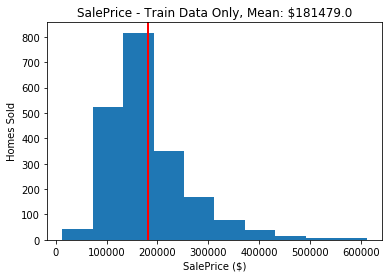

In [33]:
price_mean_str = str(round(y.mean(),0))

plt.hist(y); # SalePrice has a very right-sided fat tail
plt.title("SalePrice - Train Data Only, Mean: $"+price_mean_str);
plt.axvline(y.mean(), color='red', linewidth=2)
plt.xlabel("SalePrice ($)")
plt.ylabel("Homes Sold");

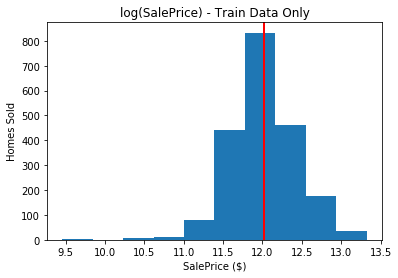

In [34]:
plt.hist(np.log(y)); # SalePrice has a very right-sided fat tail
plt.title("log(SalePrice) - Train Data Only");
plt.axvline(np.log(y).mean(), color='red', linewidth=2)
plt.xlabel("SalePrice ($)")
plt.ylabel("Homes Sold");

In [35]:
# the critical value for kurtosis under normality is 3
# the function calculates kurtosis, subtracts 3, and returns excess kurtosis
# variables with an excess kurtosis score>0 are considered non-normal and requiring of log transofrmation
def excess_kurtosis(series):
    kurtosis = sum(((series - series.mean())**4) / len(series)) / series.std() - 3
    return round(kurtosis,4)

In [36]:
# check SalePrice and log(SalePrice) for kurtosis under normality assumptions
# SalePrice has very high kurtosis but log(SalePrice) is within normality limits
print(f"The excess kurtosis score for SalePrice is {excess_kurtosis(y)}")
print(f"The excess kurtosis score for log(SalePrice) is {excess_kurtosis(np.log(y))}")

The excess kurtosis score for SalePrice is 3267972974281466.5
The excess kurtosis score for log(SalePrice) is -2.6607


In [37]:
# create a log(SalePrice) column at the end of the combined dataset
combined["SalePrice_log"] = np.log(combined["SalePrice"])

### Imputed Columns

In [38]:
# years old at sale
# Current data has year of sale and year built
combined["Years Old At Sale"] = combined["Yr Sold"] - combined["Year Built"]
print(combined["Yr Sold"].mean())
print(combined["Year Built"].mean())
print(combined["Years Old At Sale"].mean())

2007.7909121967884
1971.3190980526135
36.47181414417492


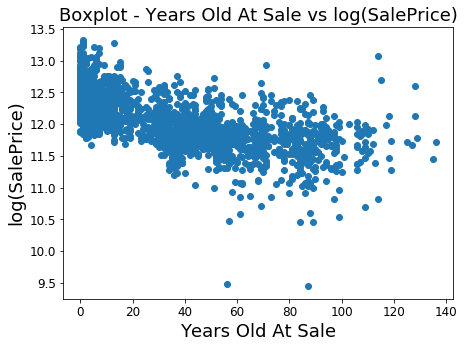

In [127]:
plt.figure(figsize=(7,5))
plt.scatter(x=train["Years Old At Sale"], y=train["SalePrice_log"]);

plt.xlabel("Years Old At Sale", fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("log(SalePrice)", fontsize=18);
plt.yticks(fontsize=12)
plt.title("Boxplot - Years Old At Sale vs log(SalePrice)", fontsize=18);

# there is a fairly linear inverse relationship between age of home and sale price
# it is unsurprising that older homes sell for less

In [39]:
# Create column for total bathrooms
# current data only has columns for full and half baths separately
combined["Total Bathrooms"] = combined["Full Bath"] + combined["Bsmt Full Bath"] + combined["Half Bath"] * 0.5 + combined["Bsmt Half Bath"] * 0.5
print(combined["Full Bath"].mean() + combined["Bsmt Full Bath"].mean())
print(combined["Half Bath"].mean() * 0.5 + combined["Bsmt Half Bath"].mean() * 0.5)
print(combined["Total Bathrooms"].mean())

1.995900239152716
0.2198496754355996
2.2157499145883155


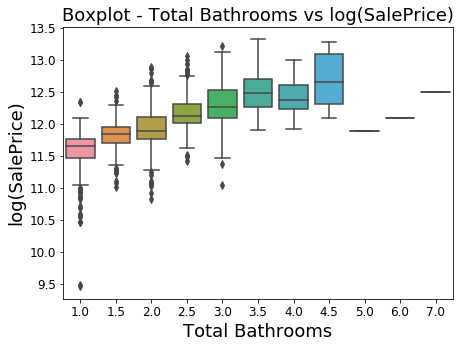

In [119]:
plt.figure(figsize=(7,5))
sns.boxplot(x=train["Total Bathrooms"],y=train["SalePrice_log"]);

plt.xlabel("Total Bathrooms", fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("log(SalePrice)", fontsize=18);
plt.yticks(fontsize=12)
plt.title("Boxplot - Total Bathrooms vs log(SalePrice)", fontsize=18);

# there is a fairly linear positive relationship between total bathrooms and sale price
# it is unsurprising that homes with more bathrooms sell for more

### Continuous Variable Selection

In [40]:
# Updating train dataset with changes made to combined dataset
train = combined[combined["dataset"] == "train"]
y = train["SalePrice"]
y_log = train["SalePrice_log"]

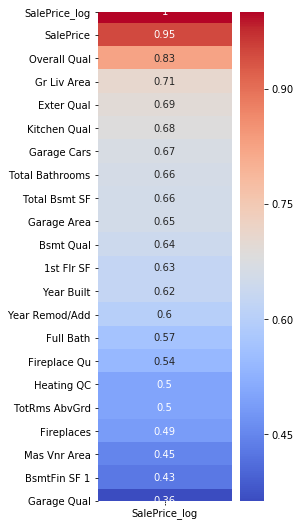

In [41]:
# Heatmap to show top 20 independent variables that are most correlated with log(SalePrice)
plt.figure(figsize=(3,9))
sns.heatmap(train.corr().sort_values(by="SalePrice_log", ascending=False).head(22)[["SalePrice_log"]],
            cmap="coolwarm",
            annot=True);

In [42]:
train.corr().sort_values(by="SalePrice_log", ascending=False).head(22).index

Index(['SalePrice_log', 'SalePrice', 'Overall Qual', 'Gr Liv Area',
       'Exter Qual', 'Kitchen Qual', 'Garage Cars', 'Total Bathrooms',
       'Total Bsmt SF', 'Garage Area', 'Bsmt Qual', '1st Flr SF', 'Year Built',
       'Year Remod/Add', 'Full Bath', 'Fireplace Qu', 'Heating QC',
       'TotRms AbvGrd', 'Fireplaces', 'Mas Vnr Area', 'BsmtFin SF 1',
       'Garage Qual'],
      dtype='object')

In [43]:
# This is a shortlist of the 5 independent variables most highly correlated with log(SalePrice)
top_5_X = ['SalePrice_log', 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual',
            'Garage Cars']

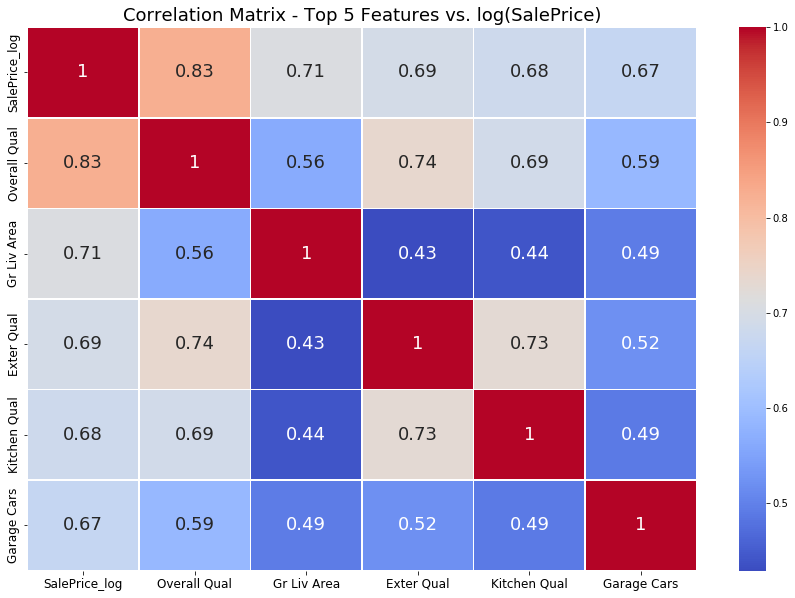

In [108]:
plt.figure(figsize=(15,10))

sns.heatmap(train.loc[:, top_5_X].corr().sort_values(by="SalePrice_log",
            ascending=False),
            cmap='coolwarm',
            annot=True,
            annot_kws={"size": 18},
            linewidths=.5);

plt.xticks(fontsize=12)
plt.yticks(fontsize=12, verticalalignment='center')
plt.title("Correlation Matrix - Top 5 Features vs. log(SalePrice)", fontsize=18);

# solution for fixing box sizes found at: https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

### Add Dummy Variables

In [45]:
# Create dummy variables for neighborhood name
neighborhood_dummies = pd.get_dummies(combined["Neighborhood"], drop_first=True)
# insert parent column name into title of dummy columns to avoid confusion
neighborhood_dummies.columns = "Neighborhood-"+ neighborhood_dummies.columns

# concatenate those dummmies to the main dataframe
combined = pd.concat([combined, neighborhood_dummies], axis=1)

In [46]:
# checking the end of the column name list to make sure concatenation happened correctly
combined.columns[80:]

Index(['Yr Sold', 'dataset', 'SalePrice_log', 'Years Old At Sale',
       'Total Bathrooms', 'Neighborhood-Blueste', 'Neighborhood-BrDale',
       'Neighborhood-BrkSide', 'Neighborhood-ClearCr', 'Neighborhood-CollgCr',
       'Neighborhood-Crawfor', 'Neighborhood-Edwards', 'Neighborhood-Gilbert',
       'Neighborhood-Greens', 'Neighborhood-GrnHill', 'Neighborhood-IDOTRR',
       'Neighborhood-Landmrk', 'Neighborhood-MeadowV', 'Neighborhood-Mitchel',
       'Neighborhood-NAmes', 'Neighborhood-NPkVill', 'Neighborhood-NWAmes',
       'Neighborhood-NoRidge', 'Neighborhood-NridgHt', 'Neighborhood-OldTown',
       'Neighborhood-SWISU', 'Neighborhood-Sawyer', 'Neighborhood-SawyerW',
       'Neighborhood-Somerst', 'Neighborhood-StoneBr', 'Neighborhood-Timber',
       'Neighborhood-Veenker'],
      dtype='object')

In [47]:
# list of the remaining text columns that need to be dummied
cols_to_dummy = ['Alley', 'Bldg Type', 'Bsmt Exposure', 'BsmtFin Type 1',
                 'BsmtFin Type 2', 'Central Air', 'Condition 1', 'Condition 2',
                 'Electrical', 'Exterior 1st', 'Exterior 2nd', 'Fence', 'Foundation',
                 'Functional', 'Garage Finish', 'Garage Type', 'Heating', 'House Style',
                 'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape', 'MS SubClass',
                 'MS Zoning', 'Mas Vnr Type', 'Misc Feature', 'Paved Drive', 'Roof Matl',
                 'Roof Style', 'Sale Type', 'Street', 'Utilities']

In [48]:
for column in cols_to_dummy:
        # Create dummy variables for neighborhood name
        dummy_cols = pd.get_dummies(combined[column], drop_first=True)
        # insert parent column name into title of dummy columns to avoid confusion
        dummy_cols.columns = column +"-"+ dummy_cols.columns
        # concatenate those dummmies to the main dataframe
        combined = pd.concat([combined, dummy_cols], axis=1)

In [49]:
combined.shape

(2927, 290)

## Model Preparation: Baseline

In [50]:
lr = LinearRegression()

In [51]:
# Updating train dataset with changes made to combined dataset
train = combined[combined["dataset"] == "train"]

target = "SalePrice_log"

y = train[target]

In [52]:
# RMSE function
def get_RMSE(y_true, y_pred):
    sq_error = (y_true - y_pred)**2
    mean_sq_error = sq_error.sum() / len(y_true)
    root_mean_sq_error = mean_sq_error **0.5
    return round(root_mean_sq_error,4)

In [53]:
# store log predictions from model 1 against all training/test data
preds_baseline = y.mean()
# store $ residuals from model 1
resids_baseline = np.exp(y) - np.exp(preds_baseline)

# this is the baseline RMSE we will optimize against
# when predicting SalePrice with just the sample avg, we get a root mean sq error of $80,590
get_RMSE(np.exp(y), np.exp(y.mean()))

80629.6145

## Model 1: MLR w/ Continuous Variables Only

In [54]:
# Updating train dataset with changes made to combined dataset
train = combined[combined["dataset"] == "train"]

target = "SalePrice_log"
mlr_variables = ['Overall Qual', 'Exter Qual','Gr Liv Area', 'Kitchen Qual', 'Garage Cars',
           'Total Bathrooms', 'Garage Area', 'Bsmt Qual', 'Year Built', 'Total Bsmt SF']

X = train[mlr_variables]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

In [55]:
# calculating and storing betas
lr.fit(X_train, y_train); 

# R2 of training set
# 80% of variance in the training set is explained by model 1 
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8504970901843075

In [56]:
# R2 of test set
# 85% of variance in the training set is explained by model 1
# this implies that we have positive variance from a decently fit model
lr.score(X_test, y_test) # test score

0.8560203006922532

In [57]:
# store $ predictions from model 1 against all training/test data
preds_m1 = np.exp(lr.predict(X))
# store $ residuals from model 1
resids_m1 = np.exp(y) - preds_m1

# when predicting SalePrice with model 1, we get a root mean sq error of $25,854
# less than one-third of the error compared to a naive model ($80,590)
get_RMSE(np.exp(y), preds_m1)

25854.4292

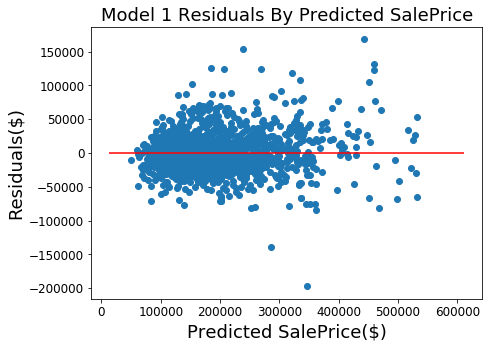

In [94]:
plt.figure(figsize=(7,5))
plt.scatter(preds_m1,resids_m1)
plt.xlabel("Predicted SalePrice($)", fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("Residuals($)", fontsize=18);
plt.yticks(fontsize=12)
plt.hlines(0, xmin=np.exp(y).min(),xmax=np.exp(y).max(), colors='red');
plt.title("Model 1 Residuals By Predicted SalePrice", fontsize=18);

In [59]:
# call the stats metrics package to interpret p-values and t-stats
# at an alpha of 5%, Exter Qual was the only p-value that did not demonstrate significance
# this column will be removed in model 2
X_adj = X
X_adj["intercept"] = 1

inference_m1 = sm.OLS(y, X_adj).fit()
inference_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1194.
Date:                Tue, 28 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:09:51   Log-Likelihood:                 884.89
No. Observations:                2049   AIC:                            -1748.
Df Residuals:                    2038   BIC:                            -1686.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Overall Qual        0.0842      0.005     18.436      0.000       0.075       0.093
Exter Qual          0.0102      0.010      0.994      0.321      -0.010       0.030
Gr Liv Area         0.0002   1.04e-05     22.537      0.000       0.000       0.000
Kitchen Qual        0.0613      0.008      7.489      0.000       0.045       0.077
Garage Cars         0.0116      0.011      1.058      0.290      -0.010       0.033
Total Bathrooms     0.0438      0.006      6.998      0.000       0.032       0.056
Garage Area         0.0002   3.79e-05      4.662      0.000       0.000       0.000
Bsmt Qual           0.0160      0.006      2.705      0.007       0.004       0.028
Year Built          0.0016      0.000      8.950      0.000       0.001       0.002
Total Bsmt SF       0.0002   1.09e-05     15.197      0.000       0.000       0.000
intercept           7.2812      0.339     21.471      0.000       6.616       7.946
==============================================================================
Omnibus:                     1086.488   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25395.642
Skew:                          -1.993   Prob(JB):                         0.00
Kurtosis:                      19.780   Cond. No.                     2.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 2: MLR w/ Continuous & Dummy Variables

In [60]:
# Updating train dataset with changes made to combined dataset
train = combined[combined["dataset"] == "train"]

target = "SalePrice_log"
mlr_variables = ['Overall Qual', 'Gr Liv Area', 'Kitchen Qual', 'Total Bathrooms',
                 'Total Bsmt SF', 'Garage Area', 'Bsmt Qual', '1st Flr SF',
                 'Year Built', 'Year Remod/Add',
                 'Neighborhood-Blueste', 'Neighborhood-BrDale','Neighborhood-BrkSide',
                 'Neighborhood-ClearCr', 'Neighborhood-CollgCr','Neighborhood-Crawfor',
                 'Neighborhood-Edwards', 'Neighborhood-Gilbert', 'Neighborhood-Greens',
                 'Neighborhood-GrnHill', 'Neighborhood-IDOTRR', 'Neighborhood-Landmrk',
                 'Neighborhood-MeadowV', 'Neighborhood-Mitchel','Neighborhood-NAmes',
                 'Neighborhood-NPkVill', 'Neighborhood-NWAmes','Neighborhood-NoRidge',
                 'Neighborhood-NridgHt', 'Neighborhood-OldTown', 'Neighborhood-SWISU',
                 'Neighborhood-Sawyer', 'Neighborhood-SawyerW', 'Neighborhood-Somerst',
                 'Neighborhood-StoneBr', 'Neighborhood-Timber','Neighborhood-Veenker']
X = train[mlr_variables]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

In [61]:
# calculating and storing betas
lr.fit(X_train, y_train); 

# R2 of training set
# 80% of variance in the training set is explained by model 1 
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8690110487638115

In [62]:
# R2 of test set
# 85% of variance in the training set is explained by model 1
# this implies that we have positive variance from a decently fit model
lr.score(X_test, y_test) # test score

0.8819976079216768

In [63]:
# store $ predictions from model 2 against all training/test data
preds_m2 = np.exp(lr.predict(X))
# store $ residuals from model 2
resids_m2 = np.exp(y) - preds_m2

# when predicting SalePrice with model 2, we get a root mean sq error of $23,939
# slightly less error compared to model 1 ($25,854)
get_RMSE(np.exp(y), preds_m2)

23939.8567

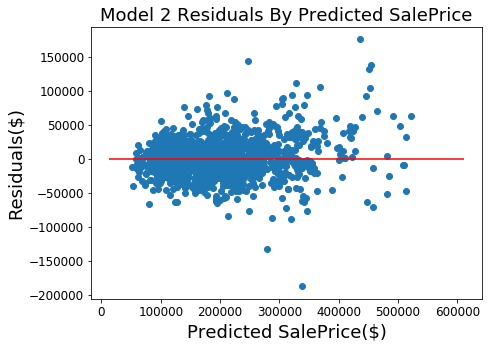

In [93]:
plt.figure(figsize=(7,5))
plt.scatter(preds_m2,resids_m2)
plt.xlabel("Predicted SalePrice($)", fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("Residuals($)", fontsize=18);
plt.yticks(fontsize=12)
plt.hlines(0, xmin=np.exp(y).min(),xmax=np.exp(y).max(), colors='red');
plt.title("Model 2 Residuals By Predicted SalePrice", fontsize=18);

In [65]:
# call the stats metrics package to interpret p-values and t-stats
# at an alpha of 5%, Exter Qual was the only p-value that did not demonstrate significance
# this column will be removed in model 2
X_adj = X
X_adj["intercept"] = 1

inference_m2 = sm.OLS(y, X_adj).fit()
inference_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     401.2
Date:                Tue, 28 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:09:51   Log-Likelihood:                 1090.6
No. Observations:                2049   AIC:                            -2105.
Df Residuals:                    2011   BIC:                            -1891.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Overall Qual             0.0811      0.004     19.066      0.000       0.073       0.089
Gr Liv Area              0.0002   1.06e-05     20.621      0.000       0.000       0.000
Kitchen Qual             0.0491      0.007      6.593      0.000       0.035       0.064
Total Bathrooms          0.0395      0.006      6.797      0.000       0.028       0.051
Total Bsmt SF         9.946e-05   1.58e-05      6.292      0.000    6.85e-05       0.000
Garage Area              0.0002   2.04e-05      9.418      0.000       0.000       0.000
Bsmt Qual                0.0296      0.006      4.808      0.000       0.018       0.042
1st Flr SF            5.451e-05   1.73e-05      3.142      0.002    2.05e-05    8.85e-05
Year Built               0.0009      0.000      3.365      0.001       0.000       0.001
Year Remod/Add           0.0017      0.000      7.327      0.000       0.001       0.002
Neighborhood-Blueste    -0.0396      0.067     -0.593      0.553      -0.171       0.091
Neighborhood-BrDale     -0.1210      0.047     -2.593      0.010      -0.212      -0.029
Neighborhood-BrkSide     0.0651      0.039      1.686      0.092      -0.011       0.141
Neighborhood-ClearCr     0.1898      0.042      4.477      0.000       0.107       0.273
Neighborhood-CollgCr     0.0478      0.033      1.459      0.145      -0.016       0.112
Neighborhood-Crawfor     0.2000      0.038      5.333      0.000       0.126       0.274
Neighborhood-Edwards     0.0173      0.035      0.489      0.625      -0.052       0.086
Neighborhood-Gilbert     0.0685      0.034      2.006      0.045       0.002       0.135
Neighborhood-Greens      0.0308      0.089      0.347      0.729      -0.143       0.205
Neighborhood-GrnHill     0.5446      0.107      5.111      0.000       0.336       0.754
Neighborhood-IDOTRR     -0.1057      0.040     -2.663      0.008      -0.184      -0.028
Neighborhood-Landmrk    -0.0613      0.147     -0.417      0.677      -0.350       0.227
Neighborhood-MeadowV    -0.0976      0.044     -2.210      0.027      -0.184      -0.011
Neighborhood-Mitchel     0.0801      0.035      2.262      0.024       0.011       0.150
Neighborhood-NAmes       0.1001      0.034      2.963      0.003       0.034       0.166
Neighborhood-NPkVill    -0.0341      0.047     -0.719      0.472      -0.127       0.059
Neighborhood-NWAmes      0.0590      0.035      1.669      0.095      -0.010       0.128
Neighborhood-NoRidge     0.0944      0.038      2.468      0.014       0.019       0.169
Neighborhood-NridgHt     0.0896      0.034      2.647      0.008       0.023       0.156
Neighborhood-OldTown    -0.0343      0.038     -0.910      0.363      -0.108       0.040
Neighborhood-SWISU       0.0218      0.044      0.501      0.617      -0.064       0.107
Neighborhood-Sawyer      0.0940      0.035      2.661    

## Model 3: Lasso

In [66]:
# Updating train dataset with changes made to combined dataset
train = combined[combined["dataset"] == "train"]

target = "SalePrice_log"

X = train.drop(columns=["SalePrice","SalePrice_log"])._get_numeric_data()
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

In [67]:
ss = StandardScaler()

# Scale all x variables into z scores
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)
Z = ss.transform(X)

In [68]:
# Create list of alpha values to iterate against
l_alphas = np.logspace(-3, 0, 100)

# cross-val over that list of alphas.
lasso_model = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)

# Fit model using best ridge alpha!
lasso_model = lasso_model.fit(Z_train, y_train)

In [69]:
# return the optimal alpha
lasso_model.alpha_

0.003511191734215131

In [70]:
# the train and test R2 scores of model 2 were 0.86 and 0.88
# the lasso model explains between 4-5% more of the variance
print(lasso_model.score(Z_train, y_train))
print(lasso_model.score(Z_test, y_test))

0.9293237407236394
0.9174595100844903


In [71]:
# store $ predictions from model 3 against all training/test data
preds_m3 = np.exp(lasso_model.predict(Z))
# store $ residuals from model 3
resids_m3 = np.exp(y) - preds_m3

# when predicting SalePrice with model 3, we get a root mean sq error of $18,951
# ~$5k less error compared to model 2 ($23,939)
get_RMSE(np.exp(y), preds_m3)

18951.269

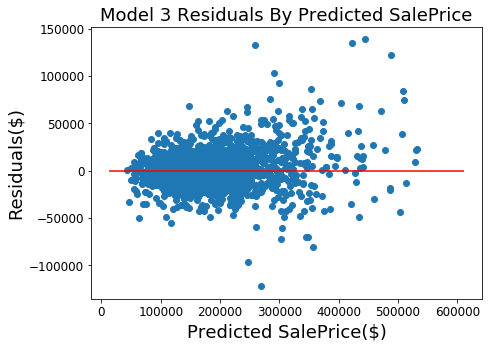

In [92]:
plt.figure(figsize=(7,5))
plt.scatter(preds_m3,resids_m3)
plt.xlabel("Predicted SalePrice($)", fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("Residuals($)", fontsize=18);
plt.yticks(fontsize=12)
plt.hlines(0, xmin=np.exp(y).min(),xmax=np.exp(y).max(), colors='red');
plt.title("Model 3 Residuals By Predicted SalePrice", fontsize=18);

## Conclusion/Recommendations

### Conclusion

- The RMSE's of the three models are as follows:
    - Model 1 Continuous Only): 25,854
    - Model 2 (Continuous + Dummies): 23,939
    - Model 3 (LASSO): 18,951
- The LASSO model is the best model of the three for the following reasons:
    - Lowest RMSE
    - Makes use of every feature
    - Zeroes out spurious variables and allows for interpretability/inference of the non-zero coefficients
- The 18,951 RMSE of the LASSO model is still a +/-10.4% error from the train set mean SalePrice (181,479)
    - Zillow's statewide median error for Iowa is only +/-1.4%

### Recommendations

- I would recommend that the LASSO model prediction be used as a supplement to Zillow's Zestimate for homes in Ames
    - Particularly when dealing with homes rated highly on the tax assessor's "Overall Quality" rating.
    - That score was most correlated with SalePrice in all three of my models
- Zillow's Zestimate is a far superior model as of now.

### Next Steps

- Update LASSO model with more recent data
    - Current dataset stops at 2010
- Incorporate real-time sale prices by neighborhood and incorporte neighborhood detail into LASSO model
    - The current model zeroes out the coefficients for most neighborhood dummies
    - Perhaps a continuous feature of avg SalePrice of the neighborhood a home is in would be better

### References
- https://www.zillow.com/zestimate/

# [Link back to top of notebook^^](#Problem-Statement)

## Kaggle Submission

WHATEVER TRANSFORMATIONS ARE DONE TO TRAINING DATASET MUST BE DONE TO VALIDATION SET

In [73]:
validation = combined[combined["dataset"] == "validation"]

In [74]:
validation.shape

(878, 290)

In [75]:
Z_validation = ss.transform(validation.drop(columns=["SalePrice","SalePrice_log"])._get_numeric_data())

preds_kaggle = np.exp(lasso_model.predict(Z_validation))

In [76]:
preds_kaggle[:10]

array([137846.82235175, 162228.49731054, 209824.46511185, 100614.83775937,
       171774.36154076,  92108.44825065, 107237.78755522, 149919.43388605,
       179661.81684237, 167705.71441046])

In [77]:
# need to submit to Kaggle in appropriate form of .csv
preds_col = pd.Series(preds_kaggle, name = "SalePrice")

# combine with Id
id_col = validation["Id"]
output = pd.concat([id_col, preds_col], axis=1)
output.head()

,Id,SalePrice
0,2658,137846.822352
1,2718,162228.497311
2,2414,209824.465112
3,1989,100614.837759
4,625,171774.361541


In [78]:
print(preds_col.shape)
print(validation["Id"].shape)

(878,)
(878,)


In [79]:
output.to_csv('./output/submission.csv', index=False)

In [80]:
train["SalePrice"].mean()

181479.01805758907

In [81]:
18951/181479

0.1044253054072372